<a href="https://colab.research.google.com/github/Saidul-1/CSE4132-Artificial-Intelligence-Lab/blob/main/Assignment11_PCA_t_sne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Discuss the feature extraction power of your favorite CNN pretrained by the ImageNet
dataset before and after transfer learning by the MNIST digit dataset after plotting high
dimensional feature vectors on 2D plane using the following two dimension reduction
techniques:
* Principal Component Analysis (PCA)
* t-distributed Stochastic Neighbor Embedding (t-SNE)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
def preprocess_data(dataset):
  (x_train, y_train), _ = dataset.load_data()

  # Use smaller subset for faster t-SNE
  x_train = x_train[:2000]
  y_train = y_train[:2000]

  # Resize
  x_train = tf.image.resize(x_train[..., np.newaxis], (224,224))

  # Convert grayscale → 3 channel
  x_train = tf.image.grayscale_to_rgb(x_train)

  x_train = preprocess_input(x_train)
  return (x_train, y_train)

In [ ]:
def feature_pca_plot(features, y_train, title):
  pca = PCA(n_components=2)
  features_pca = pca.fit_transform(features)

  plt.figure()
  plt.scatter(features_pca[:,0], features_pca[:,1], c=y_train, cmap='tab10')
  plt.title(title)
  plt.colorbar()
  plt.show()

In [ ]:
def feature_tsne_plot(features, y_train, title):
  tsne = TSNE(n_components=2, perplexity=30, random_state=42)
  features_tsne = tsne.fit_transform(features)

  plt.figure()
  plt.scatter(features_tsne[:,0], features_tsne[:,1], c=y_train, cmap='tab10')
  plt.title(title)
  plt.colorbar()
  plt.show()

In [ ]:
def main():
  mnist_x_train, mnist_y_train = preprocess_data(mnist)

  base_model = VGG16(weights='imagenet', include_top=False)
  x = GlobalAveragePooling2D()(base_model.output)
  feature_model = Model(inputs=base_model.input, outputs=x)

  # Feature Extraction and plot before transfer learning
  features_before = feature_model.predict(mnist_x_train)
  feature_pca_plot(features_before, mnist_y_train, "PCA Before Transfer Learning")
  feature_tsne_plot(features_before, mnist_y_train, "t-sne Before Transfer Learning")

  # Transfer learning - Stage 1: Freeze base model and train only the new head
  base_model.trainable = False # Freeze all layers of the base model initially
  x = GlobalAveragePooling2D()(base_model.output)
  output = Dense(10, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=output)

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  print("\nStage 1: Training only the new classification head...")
  model.fit(mnist_x_train, mnist_y_train, epochs=3) # Train for a few epochs

  # Transfer learning - Stage 2: Unfreeze selected layers and fine-tune with a lower learning rate
  base_model.trainable = True # Unfreeze the base model for selective fine-tuning
  for layer in base_model.layers:
    if "block3" in layer.name or "block4" in layer.name or "block5" in layer.name:
        layer.trainable = True # Make these blocks trainable
    else:
        layer.trainable = False # Keep other blocks frozen

  # Recompile the model with a much lower learning rate for fine-tuning
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  print("\nStage 2: Fine-tuning selected blocks with a lower learning rate...")
  model.fit(mnist_x_train, mnist_y_train, epochs=5) # Train for more epochs

  feature_model_after = Model(inputs=model.input, outputs=model.layers[-2].output)

  # Feature Extraction and plot after transfer learning
  features_after = feature_model_after.predict(mnist_x_train)

  feature_pca_plot(features_after, mnist_y_train, "PCA After Transfer Learning")
  feature_tsne_plot(features_after, mnist_y_train, "t-sne After Transfer Learning")

63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 280ms/step


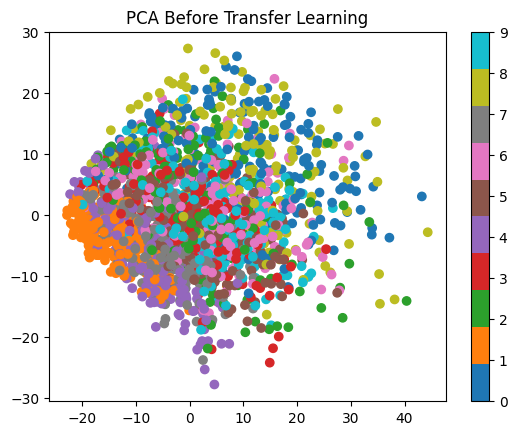

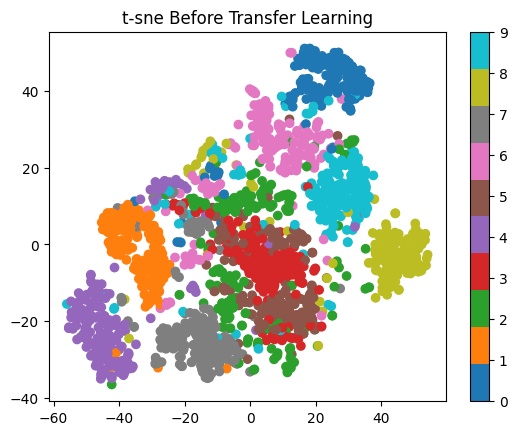


Stage 1: Training only the new classification head...
Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.1940 - loss: 3.0529
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.7381 - loss: 0.8635
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.8721 - loss: 0.4875

Stage 2: Fine-tuning selected blocks with a lower learning rate...
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 554ms/step - accuracy: 0.9383 - loss: 0.2239
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step - accuracy: 0.9873 - loss: 0.0394
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.9996 - loss: 0.0080
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 334ms/step - accuracy: 1.0000 - loss: 9.2212e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step


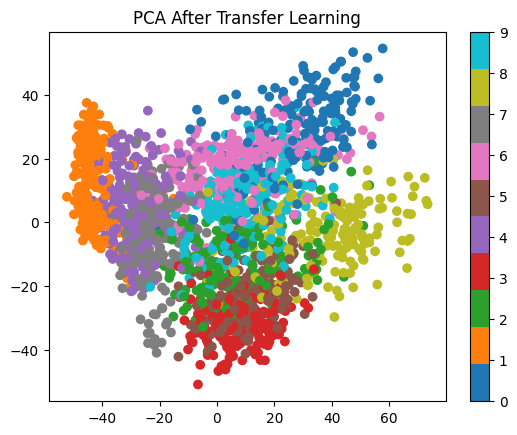

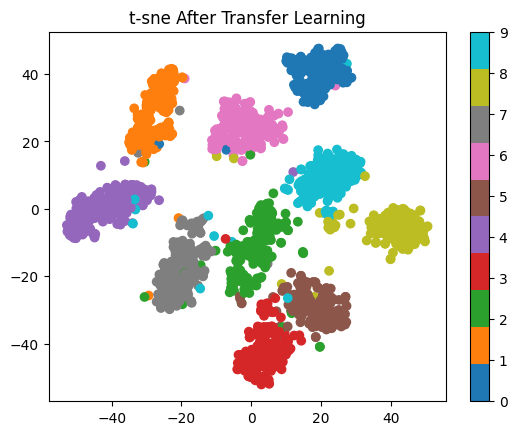

In [ ]:
if __name__ == '__main__':
    main()